In [290]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from functions import *
from helpers import *
from proj1_helpers import *
from costs import *
from data_preprocessing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

loading of the data : done


## Data preprocessing

## Logistic Regression

In [231]:
from functions import logistic_regression_GD

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large
bernoulli_feature = [11, 12]
categorical_features = [22]

# Understand The Data

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

Basic

In [4]:
n_total_training_samples = tX.shape[0]
n_total_features         = tX.shape[1]

#### columns with missing values

In [5]:
columns_with_missing_values = []
for i in range(n_total_features):
    if -999 in tX[:, i]:
        columns_with_missing_values.append(i)

columns_with_missing_values

[0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]

In [359]:
log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large (perhaps beta distribution)
bernoulli_feature = [11, 12]
categorical_features = [22]

In [166]:
def split_data(x, y, ratio_of_training):
    """split the dataset based on the split ratio."""
    p = np.random.permutation(np.arange(y.shape[0]))
    n = int(y.shape[0] * ratio_of_training)
    return  x[p][:n], x[p][n:], y[p][:n], y[p][n:]

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

In [252]:
def transform_y(y):
    tmp = y.copy()
    tmp[tmp==-1]=0
    return tmp

def transform_y_back(y):
    tmp = y.copy()
    tmp[tmp==0]=-1  
    return tmp

def prediction_and_accuracy(tr_tx, tr_y, te_tx, te_y, w):
    return accuracy(tr_y, prediction(tr_tx, w)), accuracy(te_y, prediction(te_tx, w))

# Preprocessing

#### fill missing values with their means.

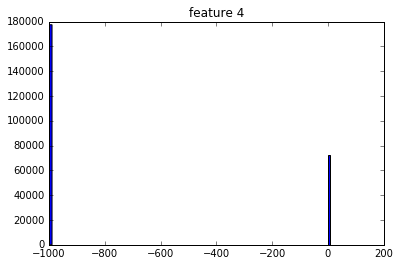

In [116]:
# Time Visualization
from ipywidgets import IntSlider, interact
from IPython.display import display

def fill_na(method=np.mean):
    filled = tX.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled

def plot_hist(tx, i, transformation=None):
    plt.figure()
    if transformation is None:
        plt.hist(tx[:, i], bins=100)
    else:
        plt.hist(transformation(tx[:, i]), bins=100)
    plt.title("feature %i" % i)
    plt.show()
    
# before processing 
interactive(lambda x:plot_hist(tX, x), x=IntSlider(min=0, max=29))

#### Expand features to reduce bias

In [133]:
def build_polynomial_without_mixed_term(tx, degree=2):
    n = tx.shape[0]
    tmp = tx
    for i in range(2, degree+1):
        tmp = np.c_[tmp, tx**i]
    # The function standardize will add a column of 1s in the first column
    return tmp

build_polynomial_without_mixed_term(np.arange(10).reshape(5,2), 3)

array([[  0,   1,   0,   1,   0,   1],
       [  2,   3,   4,   9,   8,  27],
       [  4,   5,  16,  25,  64, 125],
       [  6,   7,  36,  49, 216, 343],
       [  8,   9,  64,  81, 512, 729]])

## Classifier 1

specifications
    - polynomial of degree 2
    - didin't apply log to some features
    - validation (not cross validation)

fill -999 with mean/median/...

In [119]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

Here is the data used for interactive data analysis.

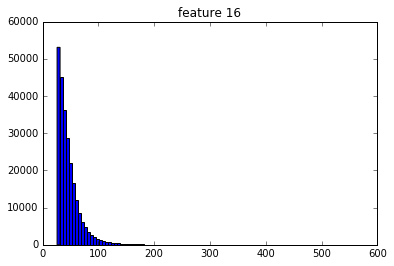

In [122]:
interactive(lambda x:plot_hist(filled_tX, x), x=IntSlider(value=1, min=0, max=n_total_features-1))

In [117]:
# some of the data is not allowed to perform log
def plot_function(idx):
    if idx in columns_non_negative:
        plot_hist(filled_tX, idx, lambda y: np.log(y+1e-6))
    else:
        pass
    
interactive(plot_function, idx=IntSlider(value=1, min=0, max=n_total_features-1))

#### standardize the columns

In [136]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 2)
## We can take logs of each column Here *******************************
tX1, mean_x1, std_x1 = standardize(tmp)
y1 = transform_y(y)
tX1.shape

(250000, 61)

### sepearte training sets and cross validation sets and Predict w

In [167]:
training_ratio = 0.9
train_tX1, cv_tX1, train_y1, cv_y1 = split_data(tX1, y1, training_ratio)
cv_tX1.shape

(25000, 61)

In [187]:
plot_info = np.array(info)
sizes = plot_info[:, 2]
tr_error = plot_info[:, 0]
te_error = plot_info[:, 1]

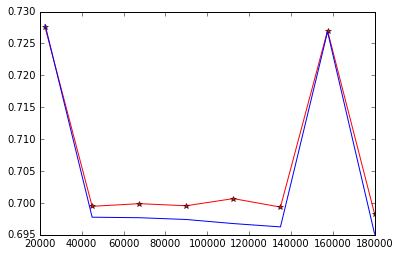

In [191]:
plt.plot(sizes, tr_error, 'r*-', sizes, te_error, 'b-')
plt.show()

## For how large the size, we can train it very accurately

gamma=0.1
lambda=0.01

|training size|iteration| acc train| acc test|
|:--:|:---:|:---:|
|100|1000| 0.98|0.70|
|150|1000|0.88|0.7|
|150|5000|0.93|0.71|
|150|10000|0.96|0.72464|
|150|20000|0.947|0.707|
|150|20000|0.953333333333| 0.70664|
|200|10000|0.885| 0.70876|
|10000|1000|0.6934| 0.69128|

we can see that with the grow of training size, the same classifier performs bad on traing set very quickly. For the same training sets, the grows of iterations can improve training performance, but can hardly influence test error.

Our model suffers from bias.

In [250]:
idxes = np.arange(200)
w, losses = reg_logistic_regression_GD(train_y1[idxes], train_tX1[idxes], gamma=0.001, 
                       max_iters = 2000, lambda_=0, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX1[idxes], train_y1[idxes], cv_tX1, cv_y1, w)
print(tr_acc, te_acc)

Losgistic Regression(0/2000): loss=2402.6957352974205
Losgistic Regression(100/2000): loss=-8936.355222308823
Losgistic Regression(200/2000): loss=-12594.63835008598
Losgistic Regression(300/2000): loss=-15025.068421770844
Losgistic Regression(400/2000): loss=-16851.15727650931
Losgistic Regression(500/2000): loss=-18322.24101198037
Losgistic Regression(600/2000): loss=-19558.5049300319
Losgistic Regression(700/2000): loss=-20626.385404283
Losgistic Regression(800/2000): loss=-21566.669930990374
Losgistic Regression(900/2000): loss=-22406.45130901868
Losgistic Regression(1000/2000): loss=-23164.809899810523
Losgistic Regression(1100/2000): loss=-23855.783145353264
Losgistic Regression(1200/2000): loss=-24490.046690219195
Losgistic Regression(1300/2000): loss=-25075.931566815303
Losgistic Regression(1400/2000): loss=-25620.074212802167
Losgistic Regression(1500/2000): loss=-26127.85080153295
Losgistic Regression(1600/2000): loss=-26603.67822884715
Losgistic Regression(1700/2000): loss=-

We see that the (original) feature 2, 4, 15, 18 has small feature in in it self, but their square can be large

In [178]:
print ("training error {e}".format(e=))
print ("training error {e}".format(e=))

training error 0.6986177777777778
training error 0.69612


# Classfier 2: Higher Order Polynomial

In [356]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

#### standardize the columns

In [253]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 3)
## We can take logs of each column Here *******************************
tX2, mean_x2, std_x2 = standardize(tmp)
y2 = transform_y(y)
tX2.shape

(250000, 91)

### sepearte training sets and cross validation sets and Predict w

In [260]:
training_ratio = 0.9
train_tX2, cv_tX2, train_y2, cv_y2 = split_data(tX2, y2, training_ratio)
cv_tX2.shape

(25000, 91)

In [357]:
idxes = np.arange(5000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

1.31858812606e-05
Losgistic Regression(0/100000): loss=-1576381.4131746194
Losgistic Regression(1000/100000): loss=-2609588.730715125
Losgistic Regression(2000/100000): loss=-3167813.2138219867
Losgistic Regression(3000/100000): loss=-3472116.763273852
Losgistic Regression(4000/100000): loss=-3685713.505443715
Losgistic Regression(5000/100000): loss=-3849144.4587358832
Losgistic Regression(6000/100000): loss=-3981252.780542511
Losgistic Regression(7000/100000): loss=-4091986.6941092336
Losgistic Regression(8000/100000): loss=-4187103.3739277883
Losgistic Regression(9000/100000): loss=-4270247.950210498
Losgistic Regression(10000/100000): loss=-4343888.490349865
Losgistic Regression(11000/100000): loss=-4409771.966527175
Losgistic Regression(12000/100000): loss=-4469173.647771348
Losgistic Regression(13000/100000): loss=-4523053.768381426
Losgistic Regression(14000/100000): loss=-4572165.075756724
Losgistic Regression(15000/100000): loss=-4617120.198719306
Losgistic Regression(16000/100

In [364]:
idxes = np.arange(10000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

6.6932772662e-06
Losgistic Regression(0/100000): loss=434457.21842224855
Losgistic Regression(1000/100000): loss=-10234622.776920963
Losgistic Regression(2000/100000): loss=-12230873.927219868
Losgistic Regression(3000/100000): loss=-13370184.385959959
Losgistic Regression(4000/100000): loss=-14177368.686676051
Losgistic Regression(5000/100000): loss=-14804224.395295477
Losgistic Regression(6000/100000): loss=-15313039.706620015
Losgistic Regression(7000/100000): loss=-15737437.263241317
Losgistic Regression(8000/100000): loss=-16098504.39866479
Losgistic Regression(9000/100000): loss=-16410311.024095053
Losgistic Regression(10000/100000): loss=-16682700.350381702
Losgistic Regression(11000/100000): loss=-16922849.827691004
Losgistic Regression(12000/100000): loss=-17136175.98913687
Losgistic Regression(13000/100000): loss=-17326879.368117437
Losgistic Regression(14000/100000): loss=-17498293.407778494
Losgistic Regression(15000/100000): loss=-17653107.48084559
Losgistic Regression(160

In [330]:
np.arange(91)[abs(w)>1]%30

array([ 0,  7, 10, 13, 16,  0,  2,  8,  9, 13, 19,  0,  1,  3,  9, 13, 19,
        0])

# Classifier 3

In [ ]:
def log_features(tx, cols):
    return tx[cols]

In [ ]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 4)
## We can take logs of each column Here *******************************
tX3, mean_x3, std_x3 = standardize(tmp)
y3 = transform_y(y)
tX3.shape

In [ ]:
idxes = np.arange(10000)
L=np.linalg.eigvals(train_tX3[idxes].T @ train_tX3[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y3[idxes], train_tX3[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX3[idxes], train_y3[idxes], cv_tX3, cv_y3, w)
print(tr_acc, te_acc)

## Generate predictions and save ouput in csv format for submission:

In [331]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [346]:
tX_test.shape

(568238, 30)

In [349]:
def fill_na_test(method=np.mean):
    filled = tX_test.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled


filled_test_tX = fill_na_test()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_test_tX[filled_test_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

In [350]:
tmp = build_polynomial_without_mixed_term(filled_test_tX, degree = 3)
## We can take logs of each column Here *******************************
test_tX, _, _ = standardize(tmp, mean_x2, std_x2)
test_tX.shape

(568238, 91)

In [352]:
y0=transform_y_back(prediction(test_tX, w))

In [354]:
y0[y0==1].shape

(177703,)

In [355]:
OUTPUT_PATH = '../results/result3.csv' # TODO: fill in desired name of output file for submission
y_pred = transform_y_back(y0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)